In [ ]:
# Run this cell only once
!git clone https://github.com/projeto-de-algoritmos/Final_DroneDeliveryScheduler
%cd Final_DroneDeliveryScheduler

In [ ]:
import delivery
from delivery.graph_utils import find_shortest_path
from mock_data.data import RandomAerialImageDataGenerator
from delivery.visualization_utils import *

from IPython.display import clear_output, display
import ipywidgets

In [ ]:
# initialize the random data generator
random_data_generator = RandomAerialImageDataGenerator(
    width=24*14,
    height=24*14,
    col_size=24,
    row_size=24,
)

In [ ]:
slider_maximum_flight_time = ipywidgets.IntSlider(
    value=13, min=1, max=90, step=1
)
slider_num_mav = ipywidgets.IntSlider(
    value=3, min=1, max=5, step=1
)
slider_num_packets = ipywidgets.IntSlider(
    value=2, min=1, max=10, step=1
)

In [ ]:
# widgets
update_data_button = ipywidgets.Button(description='UPD DATA')
update_routes_button = ipywidgets.Button(description='UPD ROUTES')

output_map = ipywidgets.Output()
output_map_with_routes = ipywidgets.Output()

In [ ]:
def update_random_data(unuseful_arg):
    global data
    # Generate random data.
    data = random_data_generator.generate(
        slider_num_packets.value
    )
    # Plot the generated map (frame grid).
    with output_map:
        clear_output(True)
        plot_frame(
            data.map,
            width=data.map.shape[0],
            height=data.map.shape[1]
        )

In [ ]:
COLOR_OPTIONS = [
    # [255,0  ,0  ],  # blue
    [255,255,0  ],  # turquoise
    [255,0  ,255],  # purple
    # [0,  0,  0  ],  # black
    # [0  ,255,0  ],  # green
    # [0  ,0  ,255],  # red
    [255,255,255],  # white
    # [0  ,255,255],  # yellow  
]
tmp_color_options = COLOR_OPTIONS[:]


def update_routes(unuseful_arg):
    # data, params
    global tmp_color_options
    path_list, distance_list = find_shortest_path(
        data.helipad_coord.copy(),
        data.goal_coord_list.copy(),
        data.adj_matrix.copy(),
        data.weight_map.copy()
    )

    frame_to_plot = data.map.copy()

    with output_map_with_routes:
        clear_output(True)
        if len(path_list) > 1:
            for path in path_list:
                if len(tmp_color_options) < 1:
                    tmp_color_options = COLOR_OPTIONS[:]
                color_idx = np.random.choice(len(tmp_color_options))
                color = tmp_color_options[color_idx][:]
                del tmp_color_options[color_idx]
                prev_coord = path[0][:]
                for coord in path[1:]:
                    frame_to_plot = cv2.line(
                        frame_to_plot,
                        (12+prev_coord[1]*random_data_generator.row_size,
                         12+prev_coord[0]*random_data_generator.col_size),
                        (12+coord[1]*random_data_generator.row_size,
                         12+coord[0]*random_data_generator.col_size),
                         color,
                         5
                    )
                    prev_coord = coord[:]
            plot_frame(
                frame_to_plot,
                width=frame_to_plot.shape[0],
                height=frame_to_plot.shape[1]
            )
        else:
            plot_frame(
                frame_to_plot,
                width=frame_to_plot.shape[0],
                height=frame_to_plot.shape[1]
            )
            print('No path found!')

In [ ]:
# slider_maximum_flight_time.observe(update_params, names='value')
# slider_num_mav.observe(update_params, names='value')
# slider_num_packets.observe(update_params, names='value')

update_data_button.on_click(update_random_data)
update_routes_button.on_click(update_routes)

In [ ]:
# initialize the app
# update_params(unuseful_arg=None)
update_random_data(unuseful_arg=None)
update_routes(unuseful_arg=None)


## **How to use**

There's a button to generate new random data and another one to update the routes. If you generate new data, please wait for the images to show up before pressing the "update routes" button.


"assets/drone_traffic.jpg"

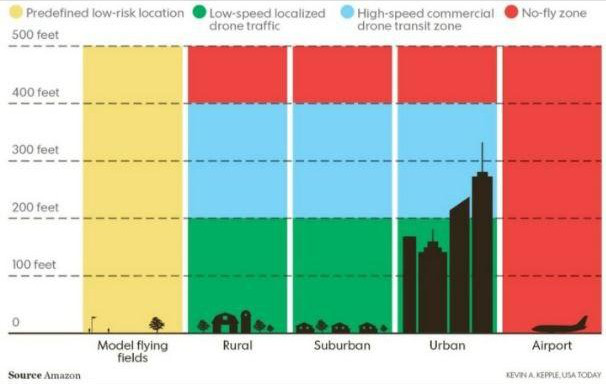

In [ ]:
from PIL import Image

Image.open("assets/drone_traffic.jpg")

### **Maximum Flight Time** (minutes)
Maximum flight time of each MAV. We assume that there's only one type of MAV and that every battery lasts the same amount of time.


In [ ]:
display(slider_maximum_flight_time)

IntSlider(value=13, max=90, min=1)

### **Number of MAVs**

In [ ]:
display(slider_num_mav)

IntSlider(value=3, max=5, min=1)

### **Number of Packets**

In [ ]:
display(slider_num_packets)

IntSlider(value=2, max=10, min=1)

### **Update the random image.**


In [ ]:
display(update_data_button)

Button(description='UPD DATA', style=ButtonStyle())

### **Update the routes.**


In [ ]:
display(update_routes_button)

Button(description='UPD ROUTES', style=ButtonStyle())

### **Random Image**

In [ ]:
display(output_map)

Output()

### **Random Image With the Routes of the MAVs**

In [ ]:
display(output_map_with_routes)

Output()